In [34]:
######################
minsep = 10.
maxsep = 90.
nbins = 15
nmult = 50
#npatch = 50
nbootstrap = 500
brute = False
nquant = 3 #No. of quantiles to split sample in Mag_K

seed1 = 12936
seed2 = 19284

passivecrop = True
write = True
plot = True
config = {"min_sep": minsep, \
          "max_sep": maxsep, \
            "nbins": nbins, \
            "sep_units": 'degree', \
            "bin_type": 'Linear', \
            "brute": brute, \
            "metric": 'Arc', \
            #"var_method": 'bootstrap', \
            #"num_bootstrap": nbootstrap,\
            }
######################

import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u
from auger_tools import generate_RandomCatalogue

# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
events_a8 = ascii.read(filename_e)
# Galaxy Mask
eve = SkyCoord(events_a8['RA'],events_a8['dec'],frame='icrs',unit='degree')
mask_eve = np.where([abs(eve.galactic.b)>5.*(u.degree)])[1]
events_a8 = events_a8[mask_eve]

# Read Gxs
if passivecrop==True: filename_g = '../data/VLS/2MRSxWISE_VLS_passivecrop.txt'
else: filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
data = ascii.read(filename_g)

# Bright/Faint
quantiles = np.quantile(data['K_abs'],np.linspace(0,1,nquant+1))

if nquant==2:
  data1 = data[data['K_abs']<quantiles[1]]
  data2 = data[data['K_abs']>quantiles[1]]
elif nquant==3:
  data1 = data[data['K_abs']<quantiles[1]]
  data2 = data[(data['K_abs']>quantiles[1])&(data['K_abs']<quantiles[2])]
  data3 = data[data['K_abs']>quantiles[2]]
elif nquant==4:
  data1 = data[data['K_abs']<quantiles[1]]
  data2 = data[(data['K_abs']>quantiles[1])&(data['K_abs']<quantiles[2])]
  data3 = data[(data['K_abs']>quantiles[2])&(data['K_abs']<quantiles[3])]
  data4 = data[data['K_abs']>quantiles[3]]

# Random Catalogue
rand_ra1, rand_dec1 = generate_RandomCatalogue(data1['_RAJ2000'],data1['_DEJ2000'],\
                                               nmult,seed1, mask=True)
rand_ra2, rand_dec2 = generate_RandomCatalogue(data2['_RAJ2000'],data2['_DEJ2000'],\
                                               nmult,seed2, mask=True)
if nquant==3:
  rand_ra3, rand_dec3 = generate_RandomCatalogue(data3['_RAJ2000'],data3['_DEJ2000'],\
                                               nmult,seed1, mask=True)
if nquant==4:
  rand_ra3, rand_dec3 = generate_RandomCatalogue(data3['_RAJ2000'],data3['_DEJ2000'],\
                                              nmult,seed1, mask=True)
  rand_ra4, rand_dec4 = generate_RandomCatalogue(data4['_RAJ2000'],data4['_DEJ2000'],\
                                              nmult,seed1, mask=True)

In [35]:
def get_xibs(data,nbootstrap,nbins,rcat,ecat,config):
    xi_bs = np.zeros((nbootstrap,nbins))
    varxi_bs = np.zeros((nbootstrap,nbins))

    dd = treecorr.NNCorrelation(config)
    dr = treecorr.NNCorrelation(config)
    rr = treecorr.NNCorrelation(config)
    rd = treecorr.NNCorrelation(config)

    for n in range(nbootstrap):
        databs = np.random.choice(data,size=len(data))
        gcat = treecorr.Catalog(ra=databs['_RAJ2000'], dec=databs['_DEJ2000'],\
                                ra_units='deg', dec_units='deg')

        rr.process(rcat)
        dd.process(gcat,ecat)
        dr.process(gcat,rcat)
        rd.process(ecat,rcat)

        xi_bs[n], varxi_bs[n] = dd.calculateXi(rr=rr,dr=dr,rd=rd)
    return xi_bs, varxi_bs, dd.meanr

import treecorr

# TreeCorr Catalogues
ecat = treecorr.Catalog(ra=events_a8['RA'], dec=events_a8['dec'], \
                        ra_units='deg', dec_units='deg')
rcat1 = treecorr.Catalog(ra=rand_ra1, dec=rand_dec1, \
                        ra_units='deg', dec_units='deg')
rcat2 = treecorr.Catalog(ra=rand_ra2, dec=rand_dec2, \
                        ra_units='deg', dec_units='deg')

if nquant==2:
    xi1_bs, varxi1_bs, th = get_xibs(data1,nbootstrap,nbins,rcat1,ecat,config)
    xi2_bs, varxi2_bs, th = get_xibs(data2,nbootstrap,nbins,rcat2,ecat,config)
if nquant==3: 
    rcat3 = treecorr.Catalog(ra=rand_ra3, dec=rand_dec3, \
                        ra_units='deg', dec_units='deg')
    xi1_bs, varxi1_bs, th = get_xibs(data1,nbootstrap,nbins,rcat1,ecat,config)
    xi2_bs, varxi2_bs, th = get_xibs(data2,nbootstrap,nbins,rcat2,ecat,config)
    xi3_bs, varxi3_bs, th = get_xibs(data3,nbootstrap,nbins,rcat3,ecat,config)
if nquant==4: 
    rcat3 = treecorr.Catalog(ra=rand_ra3, dec=rand_dec3, \
                        ra_units='deg', dec_units='deg')
    rcat4 = treecorr.Catalog(ra=rand_ra4, dec=rand_dec4, \
                        ra_units='deg', dec_units='deg')
    xi1_bs, varxi1_bs, th = get_xibs(data1,nbootstrap,nbins,rcat1,ecat,config)
    xi2_bs, varxi2_bs, th = get_xibs(data2,nbootstrap,nbins,rcat2,ecat,config)
    xi3_bs, varxi3_bs, th = get_xibs(data3,nbootstrap,nbins,rcat3,ecat,config)
    xi4_bs, varxi4_bs, th = get_xibs(data4,nbootstrap,nbins,rcat4,ecat,config)


#### Plot

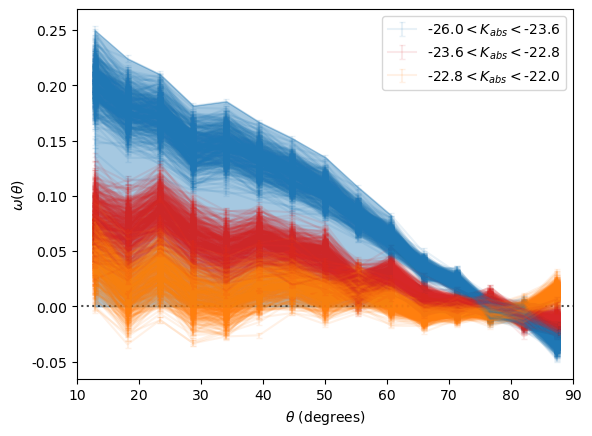

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

cutoff = 5

fig, ax = plt.subplots()

sig1 = np.sqrt(varxi1_bs)
sig2 = np.sqrt(varxi2_bs)
if nquant==3:
    sig3 = np.sqrt(varxi3_bs)
if nquant==4:
    sig3 = np.sqrt(varxi3_bs)
    sig4 = np.sqrt(varxi4_bs)

ax.hlines(0.,0.,90.,ls=':',color='k',alpha=.7)
xi1_max = [np.max(xi1_bs[:,i]) for i in range(nbins)][:-cutoff]
#xi2_max = [np.max(xi2_bs[:,i]) for i in range(nbins)][:-cutoff]
ax.fill_between(th[:-cutoff], y1=xi1_max, color='C0', alpha=.4)
#ax.fill_between(th[:-cutoff], y1=xi2_max, color='C3', alpha=.4)

alpha=.1
capsize = 2
if nquant==2:
    labels = [f'{quantiles[0]:.1f}'+r'$<K_{abs}<$'+f'{quantiles[1]:.1f}',\
              f'{quantiles[1]:.1f}'+r'$<K_{abs}<$'+f'{quantiles[2]:.1f}']
elif nquant==3:
    labels = [f'{quantiles[0]:.1f}'+r'$<K_{abs}<$'+f'{quantiles[1]:.1f}',\
              f'{quantiles[1]:.1f}'+r'$<K_{abs}<$'+f'{quantiles[2]:.1f}',\
              f'{quantiles[2]:.1f}'+r'$<K_{abs}<$'+f'{quantiles[3]:.1f}']
elif nquant==4:
    labels = [f'{quantiles[0]:.1f}'+r'$<K_{abs}<$'+f'{quantiles[1]:.1f}',\
              f'{quantiles[1]:.1f}'+r'$<K_{abs}<$'+f'{quantiles[2]:.1f}',\
              f'{quantiles[2]:.1f}'+r'$<K_{abs}<$'+f'{quantiles[3]:.1f}',\
              f'{quantiles[3]:.1f}'+r'$<K_{abs}<$'+f'{quantiles[4]:.1f}']
    
for i in range(nbootstrap):
    ax.errorbar(th, xi1_bs[i], yerr=sig1[i], color='C0', label=labels[0],\
                alpha=alpha, capsize=capsize)
    ax.errorbar(th, xi2_bs[i], yerr=sig2[i], color='C3', label=labels[1],\
                alpha=alpha, capsize=capsize)
    if nquant==3:
        ax.errorbar(th, xi3_bs[i], yerr=sig3[i], color='C1', label=labels[2],\
            alpha=alpha, capsize=capsize)
    if nquant==4:
        ax.errorbar(th, xi3_bs[i], yerr=sig3[i], color='C1', label=labels[2],\
            alpha=alpha, capsize=capsize)
        ax.errorbar(th, xi4_bs[i], yerr=sig4[i], color='C2', label=labels[3],\
            alpha=alpha, capsize=capsize)

handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0],handles[1]], [labels[0],labels[1]], loc=1)
if nquant==3:
    ax.legend([handles[0],handles[1],handles[2]], \
              [labels[0],labels[1],labels[2]], loc=1)
if nquant==4:
    ax.legend([handles[0],handles[1],handles[2],handles[3]], \
              [labels[0],labels[1],labels[2],labels[3]], loc=1)


ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$\omega(\theta)$')

ax.set_xlim([minsep,maxsep])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# if plot==True:
#     plotname = f'../data/cross_treecorr_bf_{nmult}'
#     if passivecrop==True: plotname+='_passivecrop'
#     plt.savefig(plotname+'.png')

plt.show()


#### Integration

In [37]:
from scipy import integrate

int_1 = np.zeros(nbootstrap)
int_2 = np.zeros(nbootstrap)
if nquant==3:
    int_3 = np.zeros(nbootstrap)
if nquant==4:
    int_3 = np.zeros(nbootstrap)
    int_4 = np.zeros(nbootstrap)

cutoff = 5
for i in range(nbootstrap):

    int_1[i] = integrate.simpson(xi1_bs[i][:-cutoff],x=th[:-cutoff])
    int_2[i] = integrate.simpson(xi2_bs[i][:-cutoff],x=th[:-cutoff])
    if nquant==3:
        int_3[i] = integrate.simpson(xi3_bs[i][:-cutoff],x=th[:-cutoff])
    if nquant==4:
        int_3[i] = integrate.simpson(xi3_bs[i][:-cutoff],x=th[:-cutoff])
        int_4[i] = integrate.simpson(xi4_bs[i][:-cutoff],x=th[:-cutoff])

ratio_mean = np.zeros(nquant-1)
std_mean = np.zeros(nquant-1)

if nquant==2:
    ratio_mean[0] = np.mean(int_1/int_2)
    std_mean[0] = np.std(int_1/int_2)/np.sqrt(nbootstrap)
if nquant==3:
    ratio_mean[0] = np.mean(int_1/int_3)
    std_mean[0] = np.std(int_1/int_3)/np.sqrt(nbootstrap)
    ratio_mean[1] = np.mean(int_2/int_3)
    std_mean[1] = np.std(int_2/int_3)/np.sqrt(nbootstrap)
if nquant==4:
    ratio_mean[0] = np.mean(int_1/int_4)
    std_mean[0] = np.std(int_1/int_4)/np.sqrt(nbootstrap)
    ratio_mean[1] = np.mean(int_2/int_4)
    std_mean[1] = np.std(int_2/int_4)/np.sqrt(nbootstrap)
    ratio_mean[2] = np.mean(int_3/int_4)
    std_mean[2] = np.std(int_3/int_4)/np.sqrt(nbootstrap)

print(ratio_mean, std_mean)

[10.39862615  4.53964153] [6.08128451 2.25505782]


#### Plot cocientes

[5.5082728  2.09282489] [10.39862615  4.53964153]


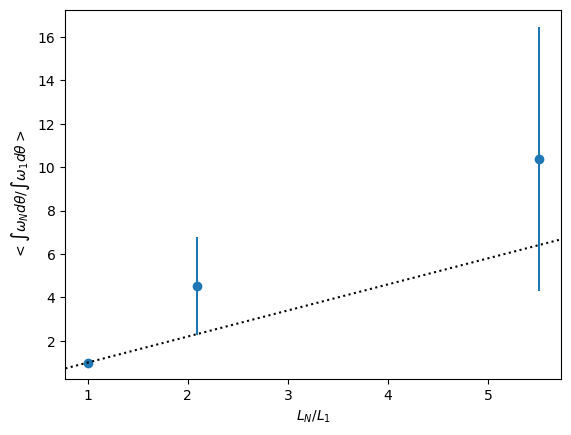

In [38]:
fig, ax = plt.subplots()

M1_mean = np.mean(data1['K_abs'])
M2_mean = np.mean(data2['K_abs'])
if nquant==3:
    M3_mean = np.mean(data3['K_abs'])
elif nquant==4:
    M3_mean = np.mean(data3['K_abs'])
    M4_mean = np.mean(data4['K_abs'])

L_ratio = np.zeros(nquant-1)
if nquant==2:
    L_ratio[0] = 10**(-.4*(M1_mean-M2_mean))
if nquant==3:
    L_ratio[0] = 10**(-.4*(M1_mean-M3_mean))
    L_ratio[1] = 10**(-.4*(M2_mean-M3_mean))
if nquant==4:
    L_ratio[0] = 10**(-.4*(M1_mean-M4_mean))
    L_ratio[1] = 10**(-.4*(M2_mean-M4_mean))
    L_ratio[2] = 10**(-.4*(M3_mean-M4_mean))

print(L_ratio,ratio_mean)

ax.scatter(1,1,c='C00')
for i in range(len(ratio_mean)):
    ax.errorbar(L_ratio[i],ratio_mean[i],yerr=std_mean[i],c='C00',fmt='o')
#ax.plot([1, 3.53], [1, 4.2])#, transform=ax.transAxes)
ax.axline((1,1),slope=4.2/3.5,c='k',ls=':')
ax.set_ylabel(r'$<\int\omega_Nd\theta/\int\omega_1d\theta>$')
ax.set_xlabel(r'$L_N/L_1$')

plt.show()